In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import os
import re
import glob
import math
import matplotlib.pyplot as plt
from pyspark.sql import functions as F
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, StringType, LongType, IntegerType
from datetime import datetime, timedelta

In [2]:
spark = (
    SparkSession.builder.appName('Outlier Analysis')
    .config("spark.sql.repl.eagerEval.enabled", True)
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .config('spark.driver.memory', '4g')
    .config('spark.executor.memory', '2g')
    .getOrCreate()
)

your 131072x1 screen size is bogus. expect trouble
24/10/02 01:09:48 WARN Utils: Your hostname, DESKTOP-F216TKE resolves to a loopback address: 127.0.1.1; using 10.255.255.254 instead (on interface lo)
24/10/02 01:09:48 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/10/02 01:09:49 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/10/02 01:09:49 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
24/10/02 01:09:49 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.


In [3]:
transactions = spark.read.parquet(".././data/curated/full_transactions")

In [4]:
transactions.show()

+--------------+------------+-------+-----------+------------------+--------------------+------------------+-----+--------+------+-----------------+--------------------+--------------------+--------------------+-----+-----+--------------+
|order_datetime|merchant_abn|user_id|consumer_id|      dollar_value|            order_id|     consumer_name|state|postcode|gender|fraud_probability|       merchant_name|                tags|               tags1|tags2|tags3|merchant_fraud|
+--------------+------------+-------+-----------+------------------+--------------------+------------------+-----+--------+------+-----------------+--------------------+--------------------+--------------------+-----+-----+--------------+
|    2022-08-25| 63290521567|  11138|     401483|41.239626303220014|09f6132a-a6a8-47a...|   Veronica Nelson|   WA|    6519|Female|             NULL|Vehicula Pellente...|[[artist supply a...|[artist supply an...|    a| 6.48|          NULL|
|    2022-08-25| 63465140133|  22285|     41

In [6]:
transactions.filter(F.isnull('fraud_probability')).count()

13543038

In [7]:
transactions.count()

13614854

In [10]:
from pyspark.sql.functions import desc

In [13]:
order_count = transactions.groupBy('merchant_abn').agg(F.count('*')).sort(desc('count(1)'))

In [16]:
order_count = order_count.toPandas()

In [18]:
order_count.to_csv('merchant_order_ranking.csv')

In [33]:
sdf = transactions.groupBy('merchant_abn').agg(F.count('*')).sort('count(1)')

In [21]:
sdf.filter(F.col('count(1)') == 1).count()

5

In [34]:
sdf.show()

+------------+--------+
|merchant_abn|count(1)|
+------------+--------+
| 10404542215|       1|
| 47047735645|       1|
| 39150153670|       1|
| 62688594508|       1|
| 93267734067|       1|
| 89133730546|       2|
| 22853038342|       2|
| 55403018592|       2|
| 46537010521|       2|
| 24212300522|       2|
| 64094501963|       2|
| 28311306642|       2|
| 86791380020|       2|
| 42461534060|       2|
| 99801770627|       2|
| 67264251405|       2|
| 67213521157|       2|
| 29068447069|       2|
| 18261886835|       2|
| 51425051982|       3|
+------------+--------+
only showing top 20 rows



In [27]:
sdf2 = transactions.groupBy('merchant_abn').agg(F.sum('dollar_value')).sort('sum(dollar_value)')

In [31]:
sdf2.show()

+------------+------------------+
|merchant_abn| sum(dollar_value)|
+------------+------------------+
| 59477140425|10064.933918748826|
| 25963848680| 10083.02879591483|
| 17028880379|10132.066442480238|
| 31570712230|10187.969786614745|
| 59873499253|10197.210888644024|
| 31468420954| 10260.20609667627|
| 18714755910|10262.411651808105|
| 73046248717| 10287.51001885235|
| 29681526553|10321.148053029814|
| 90058450104|10332.278114539173|
| 75079342466|10338.591440646454|
| 30749472383| 10362.75691439522|
| 18112900644|10362.762426049045|
| 33754604709|10365.554347418021|
| 62379298278|10400.665376571229|
| 24314208971|10401.614641683178|
| 56482885504|10500.667264235284|
| 37802138328|10539.226685287493|
| 71616292306|10567.312768510312|
| 65741331791|10587.821377264838|
+------------+------------------+
only showing top 20 rows



In [38]:
sdf.filter(F.col('merchant_abn') == '59477140425')

merchant_abn,count(1)
59477140425,19


In [49]:
groupeddata = transactions.groupBy('merchant_abn').agg(F.sum('dollar_value'), F.count("*")).sort('count(1)')

In [37]:
groupeddata = groupeddata.toPandas()
groupeddata.to_csv('groupeddata.csv')

In [39]:
values = groupeddata['sum(dollar_value)'].tolist()

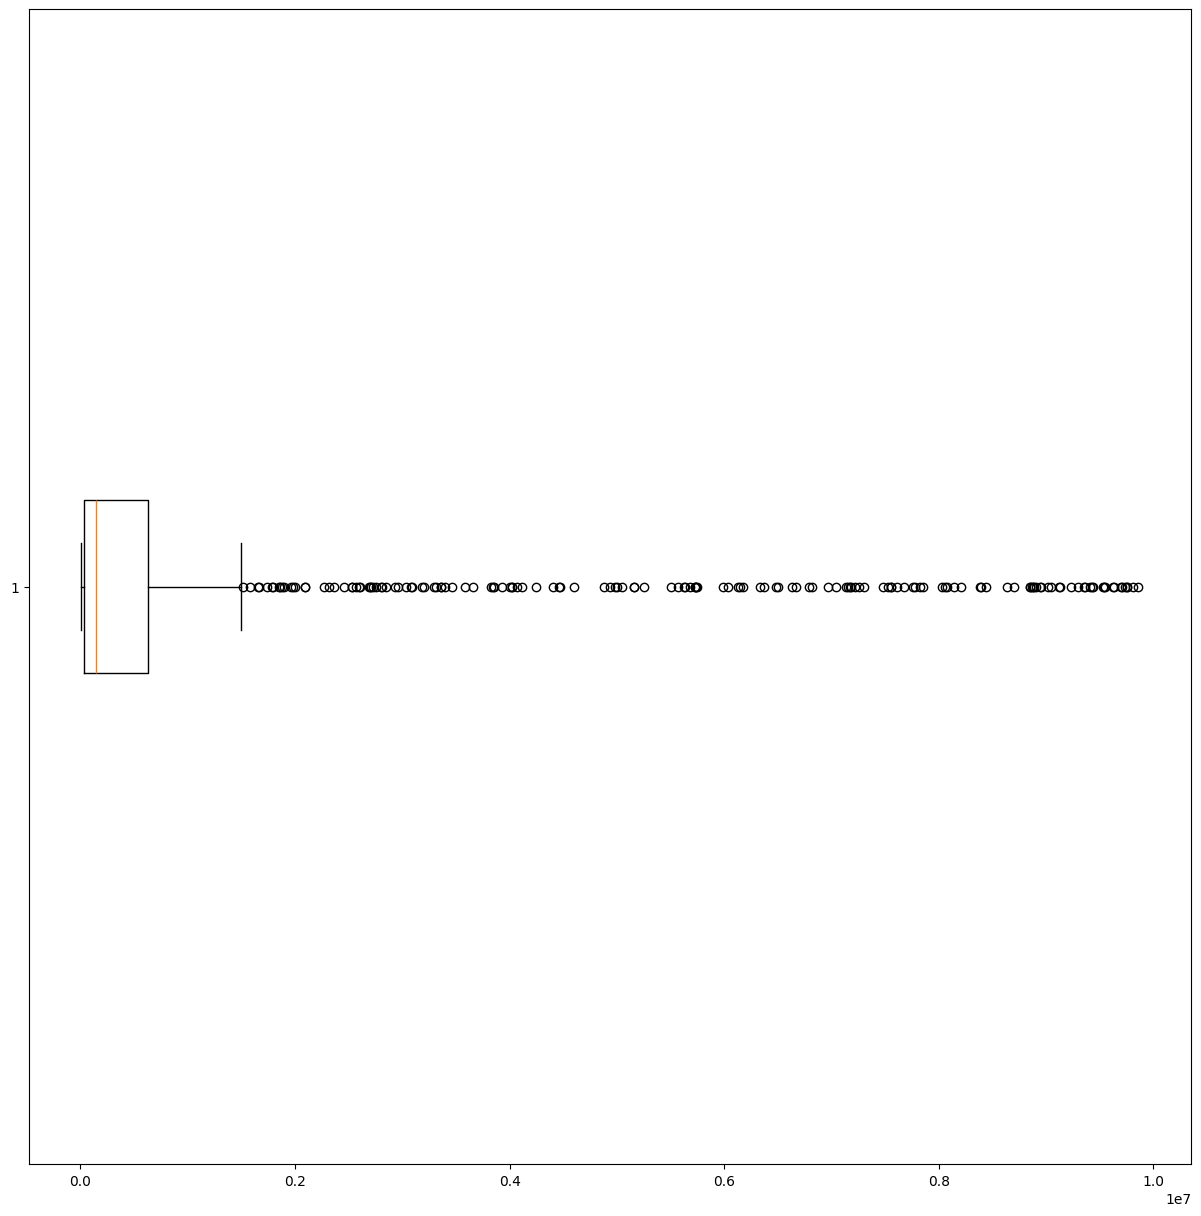

In [43]:
plt.figure(figsize=(15,15))
plt.boxplot(values, vert=False)
plt.show()

In [44]:
count = groupeddata['count(1)'].tolist()

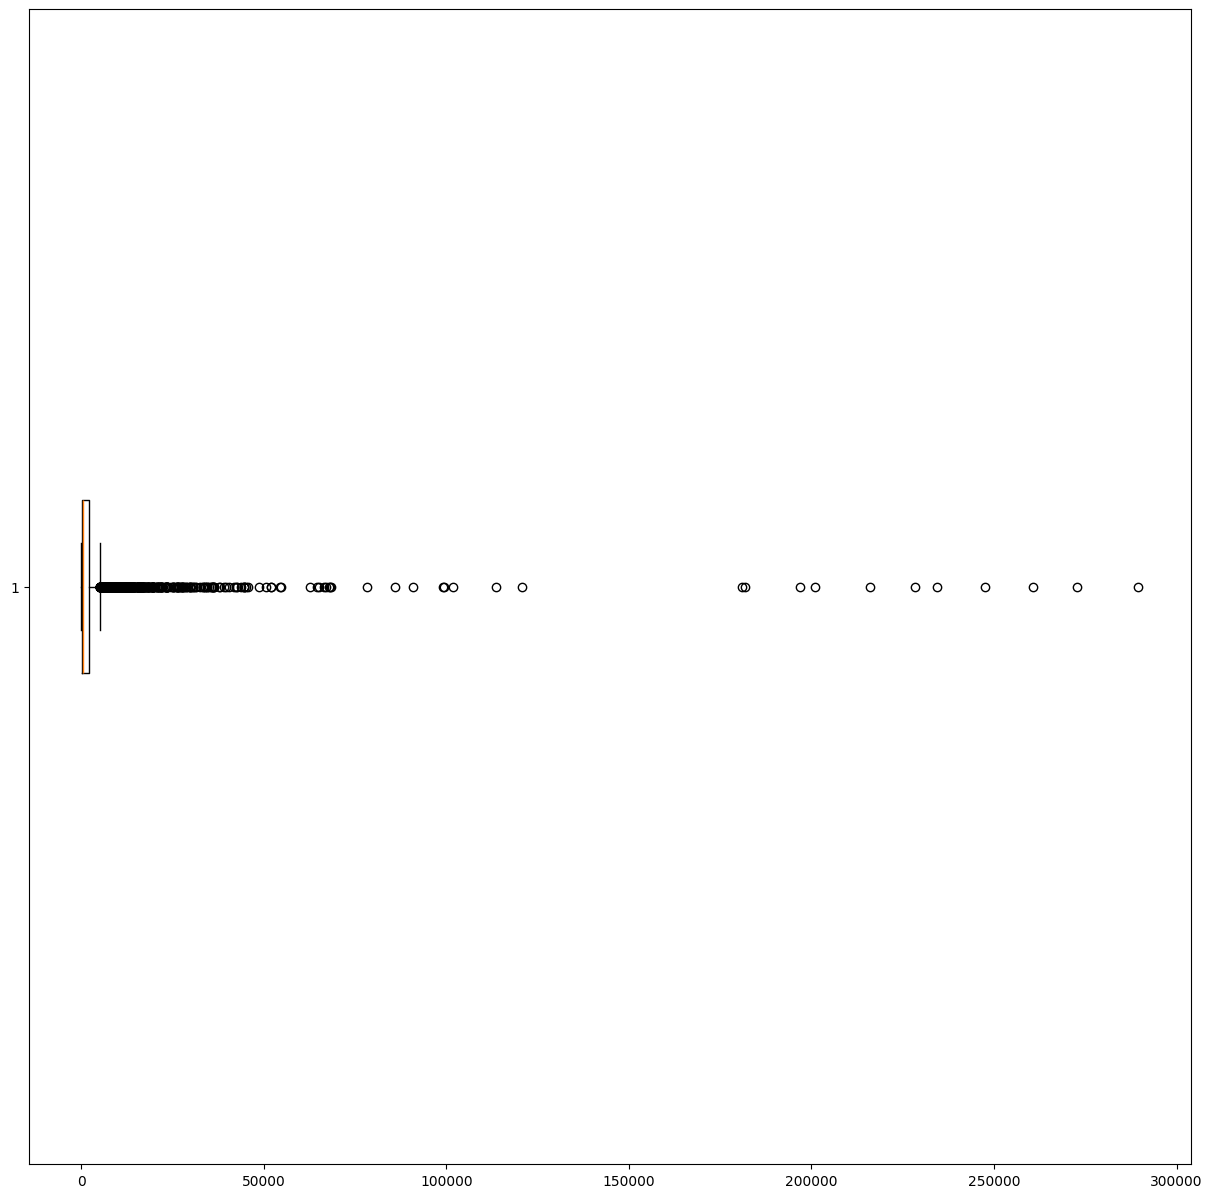

In [45]:
plt.figure(figsize=(15,15))
plt.boxplot(count, vert=False)
plt.show()

In [81]:
frauddata = transactions.groupBy('merchant_abn', 'tags1', 'tags2', 'tags3').agg(F.sum('dollar_value'), F.count("*"), F.avg('merchant_fraud')).sort(desc('sum(dollar_value)'))

In [82]:
frauddata.show(truncate=False)

+------------+----------------------------------------------------------------------------------------+-----+-----+-----------------+--------+-------------------+
|merchant_abn|tags1                                                                                   |tags2|tags3|sum(dollar_value)|count(1)|avg(merchant_fraud)|
+------------+----------------------------------------------------------------------------------------+-----+-----+-----------------+--------+-------------------+
|39649557865 |[artist supply and craft shops]                                                         |c    |1.47 |9858088.00610664 |21921   |28.690204286050626 |
|96680767841 |[motor vehicle supplies and new parts]                                                  |a    |5.91 |9806731.15347379 |31134   |29.555244690424946 |
|27093785141 |[stationery, office supplies and printing and writing paper]                            |c    |2.73 |9753403.834746331|25928   |28.952416864206434 |
|82368304209 |[telecom

In [76]:
frauddata = frauddata.toPandas()

In [77]:
frauddata.to_csv('frauddata.csv')

In [56]:
frauddata.filter(~F.isnull('avg(merchant_fraud)')).show()

+------------+------------------+--------+-------------------+
|merchant_abn| sum(dollar_value)|count(1)|avg(merchant_fraud)|
+------------+------------------+--------+-------------------+
| 67264251405|103753.27512775529|       2|  18.21089142894488|
| 89109402284|115322.18027506534|       4|  29.07408314204997|
| 91880575299| 706610.9343860475|      34|  32.99497823665355|
| 11590404675| 876549.3708413242|      52| 29.607818240092094|
| 97884414539| 772133.6891790023|      67|  89.79919971536573|
| 11149063370|1315997.4114183316|      68|  53.28693336242285|
| 79100970961|1179321.7136975033|      71|   67.1177397510102|
| 35575706403| 870494.8327536081|      75|  91.09606847149965|
| 86889657711|1203593.9098939514|      79|  63.21222581102351|
| 97217894162|1176979.6992916728|      87|  34.94582650821017|
| 72058040180|1320490.3412183248|      93|  33.71875978884334|
| 15157368385| 38675.80963318007|     125|   64.2774131928303|
| 43083074133|1193043.5221541107|     136|  48.66890735

In [55]:
frauddata.filter(~F.isnull('avg(merchant_fraud)')).count()

48

In [57]:
groupeddata.select(F.max('count(1)'))

max(count(1))
289516


In [58]:
groupeddata.select(F.min('count(1)'))

min(count(1))
1


In [60]:
groupeddata.select(F.max('sum(dollar_value)'))

max(sum(dollar_value))
9858088.00610664


In [59]:
groupeddata.select(F.min('sum(dollar_value)'))

min(sum(dollar_value))
10064.933918748826


In [68]:
df = transactions.filter(F.col('merchant_abn') == '67264251405').select(F.col('tags1')).distinct()

In [72]:
df = df.toPandas()
df['tags1'][0]

'[art dealers and galleries]'

In [50]:
import math

"""
The function below calculates the IQR and using the formula described above returns the upper and lower fence 
for the discrete feature 
"""


def calculateIQR(x):
    count = groupeddata.count()
    quantiles = groupeddata.stat.approxQuantile(x, (0.25, 0.75), 0.01)
    print(quantiles)
    iqr = quantiles[1] - quantiles[0]
    value = math.sqrt(math.log(count)-0.5) * iqr
    print(value)
    lowerfence = quantiles[0] - value
    upperfence = quantiles[1] + value
    print(upperfence, lowerfence)
    return [upperfence, lowerfence]

In [51]:
print(calculateIQR('count(1)'))

[92.0, 1930.0]
5133.42857754178
7063.42857754178 -5041.42857754178
[7063.42857754178, -5041.42857754178]


In [52]:
print(calculateIQR('sum(dollar_value)'))

[36474.52217869982, 594779.2194009967]
1559312.9965705927
2154092.2159715896 -1522838.474391893
[2154092.2159715896, -1522838.474391893]


In [92]:
gh = transactions.filter(F.col('merchant_abn')=='66667026714')

In [93]:
gh.show()

+--------------+------------+-------+-----------+------------------+--------------------+-----------------+-----+--------+-----------+-----------------+--------------------+--------------------+--------------------+-----+-----+--------------+
|order_datetime|merchant_abn|user_id|consumer_id|      dollar_value|            order_id|    consumer_name|state|postcode|     gender|fraud_probability|       merchant_name|                tags|               tags1|tags2|tags3|merchant_fraud|
+--------------+------------+-------+-----------+------------------+--------------------+-----------------+-----+--------+-----------+-----------------+--------------------+--------------------+--------------------+-----+-----+--------------+
|    2022-08-25| 66667026714|  22420|     559352|199.44461510515873|4f11041f-5c4d-4b2...|Christina Roberts|  VIC|    3711|     Female|             NULL|Sit Amet Risus Fo...|[[digital goods: ...|[digital goods: b...|    c| 1.85|          NULL|
|    2022-08-25| 66667026714

In [94]:
gh.groupBy('state').agg(F.count('*')).sort(desc('count(1)'))

state,count(1)
NSW,4350
VIC,3562
WA,2408
QLD,2242
SA,1648
TAS,520
NT,231
ACT,134


24/09/20 15:29:31 WARN HeartbeatReceiver: Removing executor driver with no recent heartbeats: 2220448 ms exceeds timeout 120000 ms
24/09/20 15:29:32 WARN SparkContext: Killing executors is not supported by current scheduler.
24/09/20 15:38:30 WARN Executor: Issue communicating with driver in heartbeater
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:101)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:85)
	at org.apache.spark.storage.BlockManagerMaster.registerBlockManager(BlockManagerMaster.scala:80)
	at org.apache.spark.storage.BlockManager.reregister(BlockManager.scala:642)
	at org.apache.spark.executor.Executor.reportHeartBeat(Executor.scala:1223)
	at 